In [1]:
import ROOT
from sys import exit
import numpy as np
from numpy.testing import assert_array_equal
from nose.tools import (raises, assert_raises, assert_true,
                        assert_equal, assert_almost_equal)
import root_numpy as rnp
import pandas as pd
from pandas.plotting import scatter_matrix
ROOT.ROOT.EnableImplicitMT()

from sklearn import preprocessing

import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

#read in key parameters from root file
#data = rnp.root2array("../data_02/mlTree.root","mltree",branches=['x','e1','e2','e3','e12','e13',
#                                                                   'e23','e123','recoilID'])

data_in = rnp.root2array("../data_02/pyTree_train.root","pytree",branches=['e0','e1','e2','x','m','gmult','ge','gid','glabel'])
assert_equal(data_in.dtype.names, ('e0','e1','e2','x','m','gmult','ge','gid','glabel'))

#convert to pandas
df = pd.DataFrame(data=data_in)

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
res_df = pd.DataFrame(x_scaled)
print(df)
print(res_df)

#data to torch tensor
X = torch.from_numpy(res_df.values).float().to(torch.device('cpu'))
print(X.shape)
print(X)


Welcome to JupyROOT 6.18/04
                e0           e1           e2           x            m  gmult  \
0      1313.433472   648.959229   713.864014  166.138184  1297.470337      4   
1      1789.049316  1042.559204  1237.864014   -9.323486  1748.345093      3   
2      2086.162354  1304.159180  1764.864014 -291.641357  1780.714600      4   
3      1592.931152   842.159180  1084.864014  -49.763672  1713.788940      3   
4      1736.203125   995.759216  1127.864014   33.885498  1484.732422      6   
...            ...          ...          ...         ...          ...    ...   
25685  1579.967651   732.273499   953.869019  -91.020752  1621.655518      5   
25686  1654.471680   921.133484  1175.869019   13.395264  1634.804810      6   
25687  1359.791626   667.103455   727.869019   14.556396  1403.743042      2   
25688  1747.879639   925.123474  1218.869019 -244.203613  1624.591553      4   
25689  1599.983643   875.913452  1051.869019   61.765625  1697.185669      5   

           

<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>

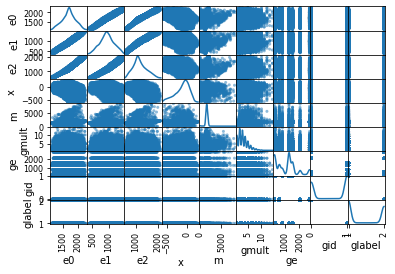

In [7]:
#look at data loaded
import matplotlib.pyplot as plt
import plotly.express as px

plt.figure(figsize=(10,4))
fig = px.histogram(df, x="glabel",nbins=8)
fig.update_xaxes(range=[-1, 3])
fig.show()

plt.figure(figsize=(10,4))
fig = px.histogram(df, x="ge",nbins=3000)
fig.update_xaxes(range=[100, 3100])
fig.show()

plt.figure(figsize=(10,4))
fig = px.scatter(df, x="e2",y="e0",color="glabel",opacity=0.5)
fig.show()


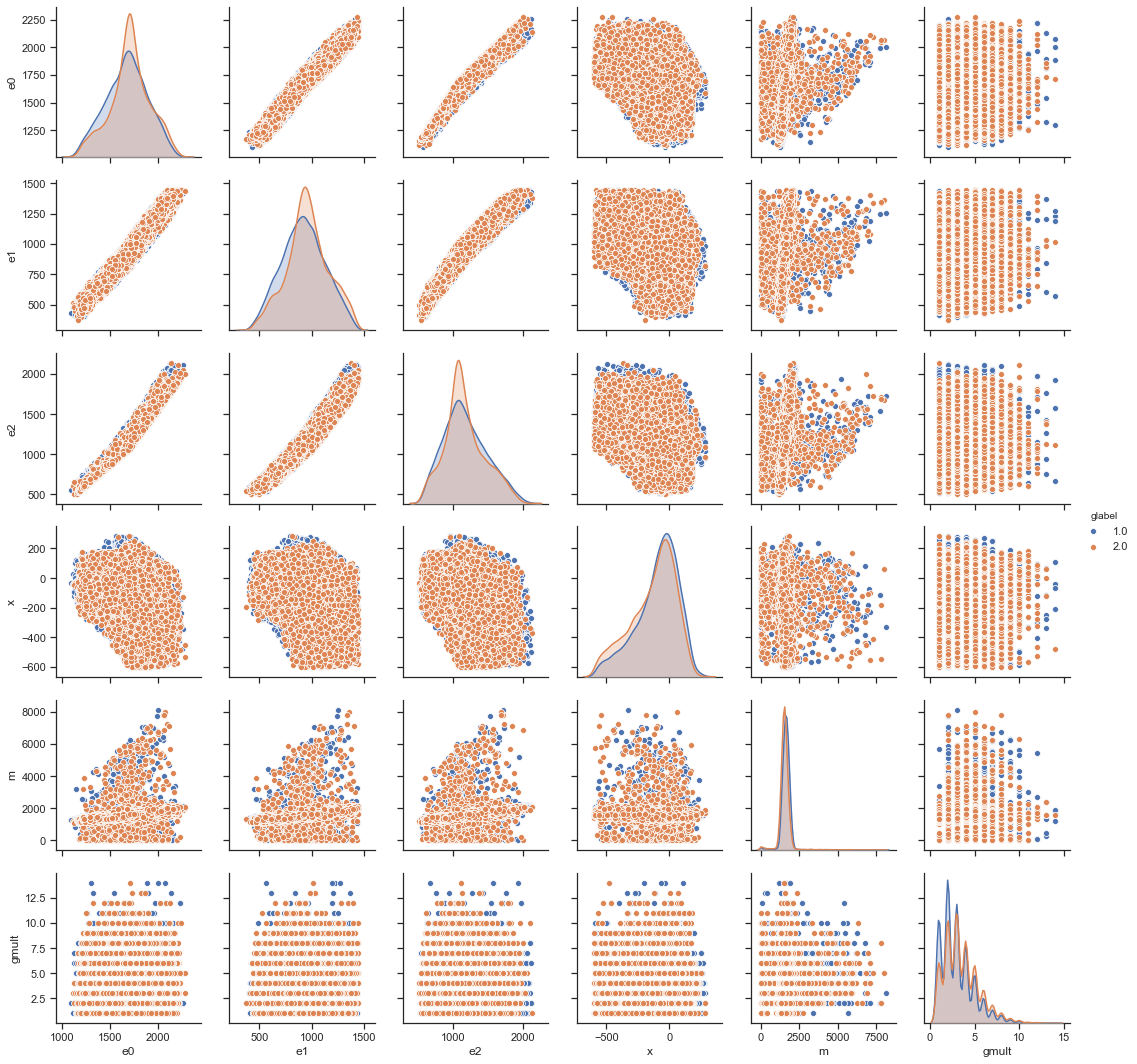

In [16]:
#plt.figure(figsize=(10,4))
#scatter_matrix(df, alpha=0.8, figsize=(4,4), diagonal='kde')
#plt.show()

import seaborn as sns
sns.set(style="ticks")

#df = sns.load_dataset("iris")
sns.pairplot(df, hue="glabel", vars=["e0", "e1", "e2", "x", "m","gmult"])

In [17]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(6, 10)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(10, 4)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(4, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    
net = Net()
opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [18]:
def train_epoch(model, opt, criterion, batch_size=500):
    model.train()
    losses = []
    correct = 0
    total = 0
    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, 0:6]
        #print(x_batch)
        y_batch = X[beg_i:beg_i + batch_size, 8:9]
        #print(y_batch.shape)
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)
        
        opt.zero_grad()
        # (1) Forward
        y_hat = net(x_batch)
        #
        # (2) Percent test on batch
        with torch.no_grad():
            y_round = torch.round(y_hat)
            total += y_batch.size(0)
            correct += (y_round == y_batch).sum().item()
            
                
        # (3) Compute diff
        loss = criterion(y_hat, y_batch)
        
        # (3) Compute gradients
        loss.backward()
        
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    
    print('Accuracy of the network on the current batch of data: %f %%' % (
        100 * correct / total))
    return losses

In [40]:
e_losses = []
num_epochs = 500
for e in range(num_epochs):
    e_losses += train_epoch(net, opt, criterion)

Accuracy of the network on the current batch of data: 76.368237 %
Accuracy of the network on the current batch of data: 76.488906 %
Accuracy of the network on the current batch of data: 76.453873 %
Accuracy of the network on the current batch of data: 76.434410 %
Accuracy of the network on the current batch of data: 76.309848 %
Accuracy of the network on the current batch of data: 76.469443 %
Accuracy of the network on the current batch of data: 76.309848 %
Accuracy of the network on the current batch of data: 76.278708 %
Accuracy of the network on the current batch of data: 76.309848 %
Accuracy of the network on the current batch of data: 76.286493 %
Accuracy of the network on the current batch of data: 76.492799 %
Accuracy of the network on the current batch of data: 76.446088 %
Accuracy of the network on the current batch of data: 76.391592 %
Accuracy of the network on the current batch of data: 76.274815 %
Accuracy of the network on the current batch of data: 76.469443 %
Accuracy o

Accuracy of the network on the current batch of data: 76.449981 %
Accuracy of the network on the current batch of data: 76.449981 %
Accuracy of the network on the current batch of data: 76.185286 %
Accuracy of the network on the current batch of data: 76.671857 %
Accuracy of the network on the current batch of data: 76.555080 %
Accuracy of the network on the current batch of data: 76.356559 %
Accuracy of the network on the current batch of data: 76.356559 %
Accuracy of the network on the current batch of data: 76.274815 %
Accuracy of the network on the current batch of data: 76.520047 %
Accuracy of the network on the current batch of data: 76.547295 %
Accuracy of the network on the current batch of data: 76.582328 %
Accuracy of the network on the current batch of data: 76.095757 %
Accuracy of the network on the current batch of data: 76.337096 %
Accuracy of the network on the current batch of data: 76.321526 %
Accuracy of the network on the current batch of data: 76.321526 %
Accuracy o

Accuracy of the network on the current batch of data: 76.340989 %
Accuracy of the network on the current batch of data: 76.395485 %
Accuracy of the network on the current batch of data: 76.453873 %
Accuracy of the network on the current batch of data: 76.516154 %
Accuracy of the network on the current batch of data: 76.488906 %
Accuracy of the network on the current batch of data: 76.558972 %
Accuracy of the network on the current batch of data: 76.360452 %
Accuracy of the network on the current batch of data: 76.383807 %
Accuracy of the network on the current batch of data: 76.364344 %
Accuracy of the network on the current batch of data: 76.302063 %
Accuracy of the network on the current batch of data: 76.442195 %
Accuracy of the network on the current batch of data: 76.481121 %
Accuracy of the network on the current batch of data: 76.395485 %
Accuracy of the network on the current batch of data: 76.453873 %
Accuracy of the network on the current batch of data: 76.543402 %
Accuracy o

Accuracy of the network on the current batch of data: 76.531724 %
Accuracy of the network on the current batch of data: 76.360452 %
Accuracy of the network on the current batch of data: 76.434410 %
Accuracy of the network on the current batch of data: 76.578435 %
Accuracy of the network on the current batch of data: 76.204749 %
Accuracy of the network on the current batch of data: 76.348774 %
Accuracy of the network on the current batch of data: 76.683534 %
Accuracy of the network on the current batch of data: 76.321526 %
Accuracy of the network on the current batch of data: 76.333204 %
Accuracy of the network on the current batch of data: 76.333204 %
Accuracy of the network on the current batch of data: 76.453873 %
Accuracy of the network on the current batch of data: 76.313741 %
Accuracy of the network on the current batch of data: 76.130790 %
Accuracy of the network on the current batch of data: 76.438303 %
Accuracy of the network on the current batch of data: 76.469443 %
Accuracy o

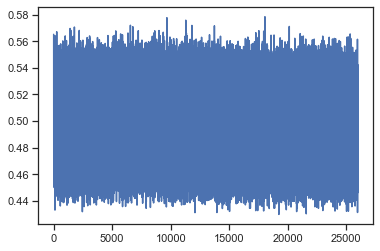

In [41]:
plt.plot(e_losses)

In [42]:
x_t = Variable(torch.randn(1, 5))
net.eval()
with torch.no_grad():
    result = net(X[0:100000,0:6])

In [43]:
#plt.plot(result.data)
print(torch.max(result))
print(torch.min(result))
torch.histc(result)
#print(result.data)

df_F = pd.DataFrame(data=result.numpy())
#print(df_F)
df_F.columns = ["A"]

fig = px.histogram(df_F,x="A",nbins=100)
fig.update_xaxes(range=[0.0,1.0])
fig.show()



tensor(0.8910)
tensor(0.0489)
